In [1]:
import torch 
from torchvision import datasets,transforms as T,models
from torch import optim,nn
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
from torch.utils.data import DataLoader
import hiddenlayer as hl
import numpy as np
torch.cuda.empty_cache()

In [2]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir  = 'data/test'

In [3]:
train_transform = T.Compose([
    T.Resize((320,320)),
    T.CenterCrop(299),
    T.RandomRotation(0,359),
    T.RandomHorizontalFlip(p = 0.5),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


valid_transform = T.Compose([
    T.Resize((320,320)),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transfrom = valid_transform

In [4]:
trainset = datasets.ImageFolder(train_dir,transform = train_transform)

validset = datasets.ImageFolder(valid_dir,transform = valid_transform)

testset = datasets.ImageFolder(test_dir,transform = test_transfrom)

In [15]:
trainloader = DataLoader(trainset, batch_size = 64,shuffle = True)
validloader = DataLoader(validset, batch_size = 64,shuffle = True)
testloader = DataLoader(testset, batch_size = 64,shuffle = True)

In [16]:
#Total no. of examples in Training Set
#Total no. of examples Validation set
#Total no. of examples test set

print(len(trainset))
print(len(validset))
#print(len(testset))

2000
150


In [17]:
#Total no. of Batch for TrainSet
#Total no. of Batch for ValidSet
#Total no. of Batch for TestSet

print(len(trainloader))
print(len(validloader))
#print(len(testloader))

32
3


In [18]:
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image) 

classes = ['melanoma','nevus','seborrheic_keratosis']

In [19]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 299, 299])
torch.Size([64])


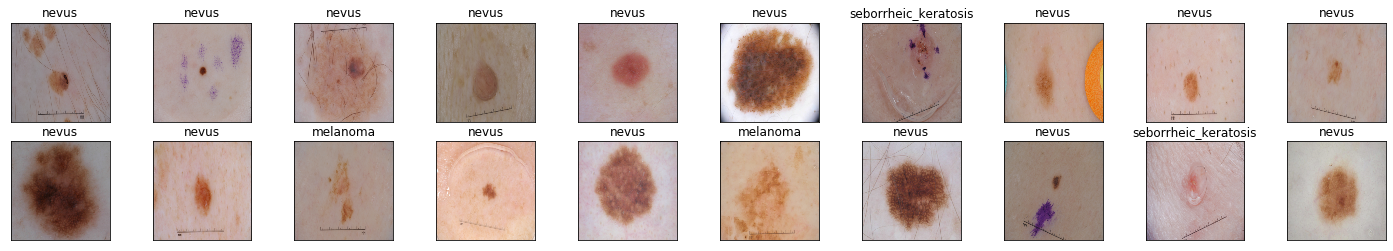

In [20]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [21]:
model = models.inception_v3(pretrained=True)

In [22]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(2048,1024)),
    ('relu',nn.ReLU()),
    ('dropout',nn.Dropout(0.5)),
    ('fc2',nn.Linear(1024,500)),
    ('relu',nn.ReLU()),
    ('dropout',nn.Dropout(0.5)),
    ('fc3',nn.Linear(500,3)),
    ('output',nn.LogSoftmax(dim = 1))
]))

model.fc = fc
model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:
epochs = 30 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(),lr = 0.003)
print_every = 1

train_loss_data = []
val_loss_data = []

valid_loss_min = np.Inf

for i in range(epochs):

    train_loss = 0
    val_loss = 0
    train_run = 0

    model.train()
    batch_id = 0
    for images, labels in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        
        logps,aux = model(images)
        optimizer.zero_grad()
        loss = criterion(logps,labels)
        loss.backward()
        optimizer.step()
        
        train_run += loss.item()
        train_loss += loss.item()*images.size(0)

       
        
    
    model.eval()
    for images,labels in validloader:
        
        images = images.cuda()
        labels = labels.cuda()

        logps = model(images)
        loss = criterion(logps,labels)
        val_loss += loss.item()*images.size(0)

     

    train_loss = train_loss/len(trainloader.dataset)
    val_loss = val_loss/len(validloader.dataset)
  

    train_loss_data.append(train_loss)
    val_loss_data.append(val_loss)
   

    print("Epoch : {} training Loss : {:.6f} Validation Loss : {:.6f} ".format(i+1,train_loss,val_loss))


    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,val_loss))
        torch.save(model.state_dict(), 'SkinCancerModel.pt')
        valid_loss_min = val_loss

Epoch : 1 training Loss : 1.144783 Validation Loss : 0.986635 
Validation loss decreased (inf --> 0.986635).   Saving model ...
Epoch : 2 training Loss : 0.796768 Validation Loss : 0.931788 
Validation loss decreased (0.986635 --> 0.931788).   Saving model ...
Epoch : 3 training Loss : 0.769907 Validation Loss : 0.838782 
Validation loss decreased (0.931788 --> 0.838782).   Saving model ...
Epoch : 4 training Loss : 0.765874 Validation Loss : 0.885607 
Epoch : 5 training Loss : 0.750223 Validation Loss : 0.898767 
Epoch : 6 training Loss : 0.738947 Validation Loss : 1.131855 
Epoch : 7 training Loss : 0.754453 Validation Loss : 0.900308 
Epoch : 8 training Loss : 0.746588 Validation Loss : 0.874615 
Epoch : 9 training Loss : 0.767912 Validation Loss : 0.919151 
Epoch : 10 training Loss : 0.725462 Validation Loss : 0.881685 
Epoch : 11 training Loss : 0.730546 Validation Loss : 0.880443 
Epoch : 12 training Loss : 0.709237 Validation Loss : 0.927507 
Epoch : 13 training Loss : 0.718273 